- 자연어 (Word2Vec 위주) 강의를 통해 공부한 내용입니다
- 데이터셋은 카글 데이터를 이용하였습니다 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

: 

In [ ]:
import pandas as pd

train = pd.read_csv('data/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
test = pd.read_csv('data/testData.tsv', 
                   header=0, delimiter='\t', quoting=3)
unlabeled_train = pd.read_csv('data/unlabeledTrainData.tsv', 
                              header=0, delimiter='\t', quoting=3)

print(train.shape)
print(test.shape)
print(unlabeled_train.shape)

print(train['review'].size)
print(test['review'].size)
print(unlabeled_train['review'].size)

(25000, 3)
(25000, 2)
(50000, 2)
25000
25000
50000


In [ ]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
# train에 있는 평점정보인 sentiment가 없다.
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [ ]:
from KaggleWord2VecUtility import KaggleWord2VecUtility 

In [ ]:
KaggleWord2VecUtility.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [ ]:
sentences = []
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

In [ ]:
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

In [ ]:
len(sentences)

795538

In [ ]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [ ]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

### Word2Vec 모델을 학습
전처리를 거쳐 파싱된 문장의 목록으로 모델을 학습시킬 준비가 되었다.

## Gensim
* [gensim: models.word2vec – Deep learning with word2vec](https://radimrehurek.com/gensim/models/word2vec.html)

### Word2Vec 모델의 파라메터

* 아키텍처 : 아키텍처 옵션은 skip-gram (default) 또는  CBOW 모델이다. skip-gram (default)은 느리지 만 더 나은 결과를 낸다.

* 학습 알고리즘 : Hierarchical softmax (default) 또는 negative 샘플링. 여기에서는 기본값이 잘 동작한다.

* 빈번하게 등장하는 단어에 대한 다운 샘플링 : Google 문서는 .00001에서 .001 사이의 값을 권장한다. 여기에서는 0.001에 가까운 값이 최종 모델의 정확도를 높이는 것으로 보여진다.

* 단어 벡터 차원 : 많은 feature를 사용한다고 항상 좋은 것은 아니지만 대체적으로 좀 더 나은 모델이 된다. 합리적인 값은 수십에서 수백 개가 될 수 있고 여기에서는 300으로 지정했다.

* 컨텍스트 / 창 크기 : 학습 알고리즘이 고려해야하는 컨텍스트의 단어 수는 얼마나 될까? hierarchical softmax 를 위해 좀 더 큰 수가 좋지만 10 정도가 적당하다. 

* Worker threads : 실행할 병렬 프로세스의 수로 컴퓨터마다 다르지만 대부분의 시스템에서 4에서 6 사이의 값을 사용하다.

* 최소 단어 수 : 어휘의 크기를 의미있는 단어로 제한하는 데 도움이 된다. 모든 문서에서이 여러 번 발생하지 않는 단어는 무시된다. 10에서 100 사이가 적당하며, 이 경진대회의 데이터는 각 영화가 30개씩의 리뷰가 있기 때문에 개별 영화 제목에 너무 많은 중요성이 붙는 것을 피하기 위해 최소 단어 수를 40으로 설정한다. 그 결과 전체 어휘 크기는 약 15,000 단어가 된다. 높은 값은 제한 된 실행시간에 도움이 된다.

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [ ]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2018-01-16 15:46:48,195 : INFO : 'pattern' package not found; tag filters are not available for English
2018-01-16 15:46:48,202 : INFO : collecting all words and their counts
2018-01-16 15:46:48,203 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-16 15:46:48,267 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2018-01-16 15:46:48,338 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2018-01-16 15:46:48,431 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2018-01-16 15:46:48,523 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2018-01-16 15:46:48,579 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types
2018-01-16 15:46:48,633 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2018-01-16 15:46:48,690 : INFO : PROGRESS: at senten

2018-01-16 15:46:52,539 : INFO : PROGRESS: at sentence #710000, processed 15880371 words, keeping 82560 word types
2018-01-16 15:46:52,600 : INFO : PROGRESS: at sentence #720000, processed 16105658 words, keeping 83036 word types
2018-01-16 15:46:52,665 : INFO : PROGRESS: at sentence #730000, processed 16332039 words, keeping 83571 word types
2018-01-16 15:46:52,717 : INFO : PROGRESS: at sentence #740000, processed 16553072 words, keeping 84127 word types
2018-01-16 15:46:52,778 : INFO : PROGRESS: at sentence #750000, processed 16771399 words, keeping 84599 word types
2018-01-16 15:46:52,827 : INFO : PROGRESS: at sentence #760000, processed 16990803 words, keeping 85068 word types
2018-01-16 15:46:52,890 : INFO : PROGRESS: at sentence #770000, processed 17217940 words, keeping 85644 word types
2018-01-16 15:46:52,943 : INFO : PROGRESS: at sentence #780000, processed 17448086 words, keeping 86160 word types
2018-01-16 15:46:52,996 : INFO : PROGRESS: at sentence #790000, processed 176751

2018-01-16 15:47:54,941 : INFO : PROGRESS: at 52.36% examples, 547415 words/s, in_qsize 8, out_qsize 1
2018-01-16 15:47:55,946 : INFO : PROGRESS: at 53.26% examples, 547859 words/s, in_qsize 7, out_qsize 0
2018-01-16 15:47:56,951 : INFO : PROGRESS: at 53.92% examples, 545889 words/s, in_qsize 8, out_qsize 0
2018-01-16 15:47:57,953 : INFO : PROGRESS: at 54.66% examples, 544813 words/s, in_qsize 8, out_qsize 0
2018-01-16 15:47:58,970 : INFO : PROGRESS: at 55.34% examples, 543078 words/s, in_qsize 7, out_qsize 0
2018-01-16 15:47:59,994 : INFO : PROGRESS: at 56.06% examples, 541667 words/s, in_qsize 8, out_qsize 0
2018-01-16 15:48:01,081 : INFO : PROGRESS: at 56.81% examples, 540118 words/s, in_qsize 6, out_qsize 1
2018-01-16 15:48:02,081 : INFO : PROGRESS: at 57.52% examples, 538876 words/s, in_qsize 8, out_qsize 0
2018-01-16 15:48:03,133 : INFO : PROGRESS: at 58.04% examples, 535610 words/s, in_qsize 6, out_qsize 1
2018-01-16 15:48:04,150 : INFO : PROGRESS: at 58.70% examples, 533930 wor

In [ ]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'
model.save(model_name)

2018-01-16 15:49:08,408 : INFO : precomputing L2-norms of word weight vectors
2018-01-16 15:49:08,588 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2018-01-16 15:49:08,589 : INFO : not storing attribute syn0norm
2018-01-16 15:49:08,592 : INFO : not storing attribute cum_table
2018-01-16 15:49:09,237 : INFO : saved 300features_40minwords_10text


## 모델 결과 탐색 
Exploring the Model Results

In [ ]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [ ]:
model.wv.doesnt_match("france england germany berlin".split())

2018-01-16 15:49:09,270 : WARNING : vectors for words {'france', 'germany'} are not present in the model, ignoring these words


'berlin'

In [ ]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

[('woman', 0.6346021890640259),
 ('businessman', 0.5241227746009827),
 ('ladi', 0.5211358070373535),
 ('lad', 0.5165952444076538),
 ('millionair', 0.49945348501205444),
 ('farmer', 0.4661444127559662),
 ('men', 0.46612322330474854),
 ('boxer', 0.4650130271911621),
 ('widow', 0.4628654718399048),
 ('policeman', 0.4608388841152191)]

In [ ]:
model.wv.most_similar("queen")

[('princess', 0.5980467200279236),
 ('goddess', 0.5464529991149902),
 ('victoria', 0.5335069894790649),
 ('seductress', 0.5329927802085876),
 ('latifah', 0.5239185690879822),
 ('stepmoth', 0.5189395546913147),
 ('bride', 0.5187833905220032),
 ('nun', 0.5187197327613831),
 ('maria', 0.5130434632301331),
 ('maid', 0.5088884234428406)]

In [ ]:
# model.wv.most_similar("awful")

In [ ]:
model.wv.most_similar("film")

[('movi', 0.8506779074668884),
 ('flick', 0.6001852750778198),
 ('documentari', 0.5914444327354431),
 ('pictur', 0.5582413673400879),
 ('cinema', 0.5267403721809387),
 ('sequel', 0.4961458146572113),
 ('masterpiec', 0.4919975996017456),
 ('it', 0.483654648065567),
 ('genr', 0.4749864637851715),
 ('effort', 0.4723205268383026)]

In [ ]:
# model.wv.most_similar("happy")
model.wv.most_similar("happi") # stemming 처리 시 

[('unhappi', 0.42357802391052246),
 ('satisfi', 0.4157138466835022),
 ('sad', 0.407173216342926),
 ('glad', 0.3871932029724121),
 ('lucki', 0.3831247389316559),
 ('afraid', 0.37879762053489685),
 ('anxious', 0.36728110909461975),
 ('bitter', 0.3594135642051697),
 ('upset', 0.3593282699584961),
 ('joy', 0.3521401286125183)]

### Word2Vec으로 벡터화 한 단어를 t-SNE 를 통해 시각화

In [ ]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2018-01-16 15:49:09,712 : INFO : loading Doc2Vec object from 300features_40minwords_10text
2018-01-16 15:49:09,977 : INFO : loading wv recursively from 300features_40minwords_10text.wv.* with mmap=None
2018-01-16 15:49:09,978 : INFO : setting ignored attribute syn0norm to None
2018-01-16 15:49:09,980 : INFO : setting ignored attribute cum_table to None
2018-01-16 15:49:09,981 : INFO : loaded 300features_40minwords_10text


11986
[ 0.08096986 -0.05534305  0.16620259  0.04356802 -0.00589749 -0.02075242
  0.02598226  0.07634024  0.00546919  0.08736426]


In [ ]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [ ]:
df.head(10)

,x,y
with,3.399101,-2.212670
all,-4.684950,1.340348
this,-3.472565,-0.517563
stuff,-5.893897,0.499611
go,-4.214260,-6.399875
down,4.853176,-5.858385
at,2.976999,-5.427274
the,-4.934722,2.948591
moment,-3.556630,4.883556
mj,5.769177,4.133462


밑에 이거는 태윤이가 좋아하는 그거를 개념상으로 유사한 애들끼리 묶은 거임

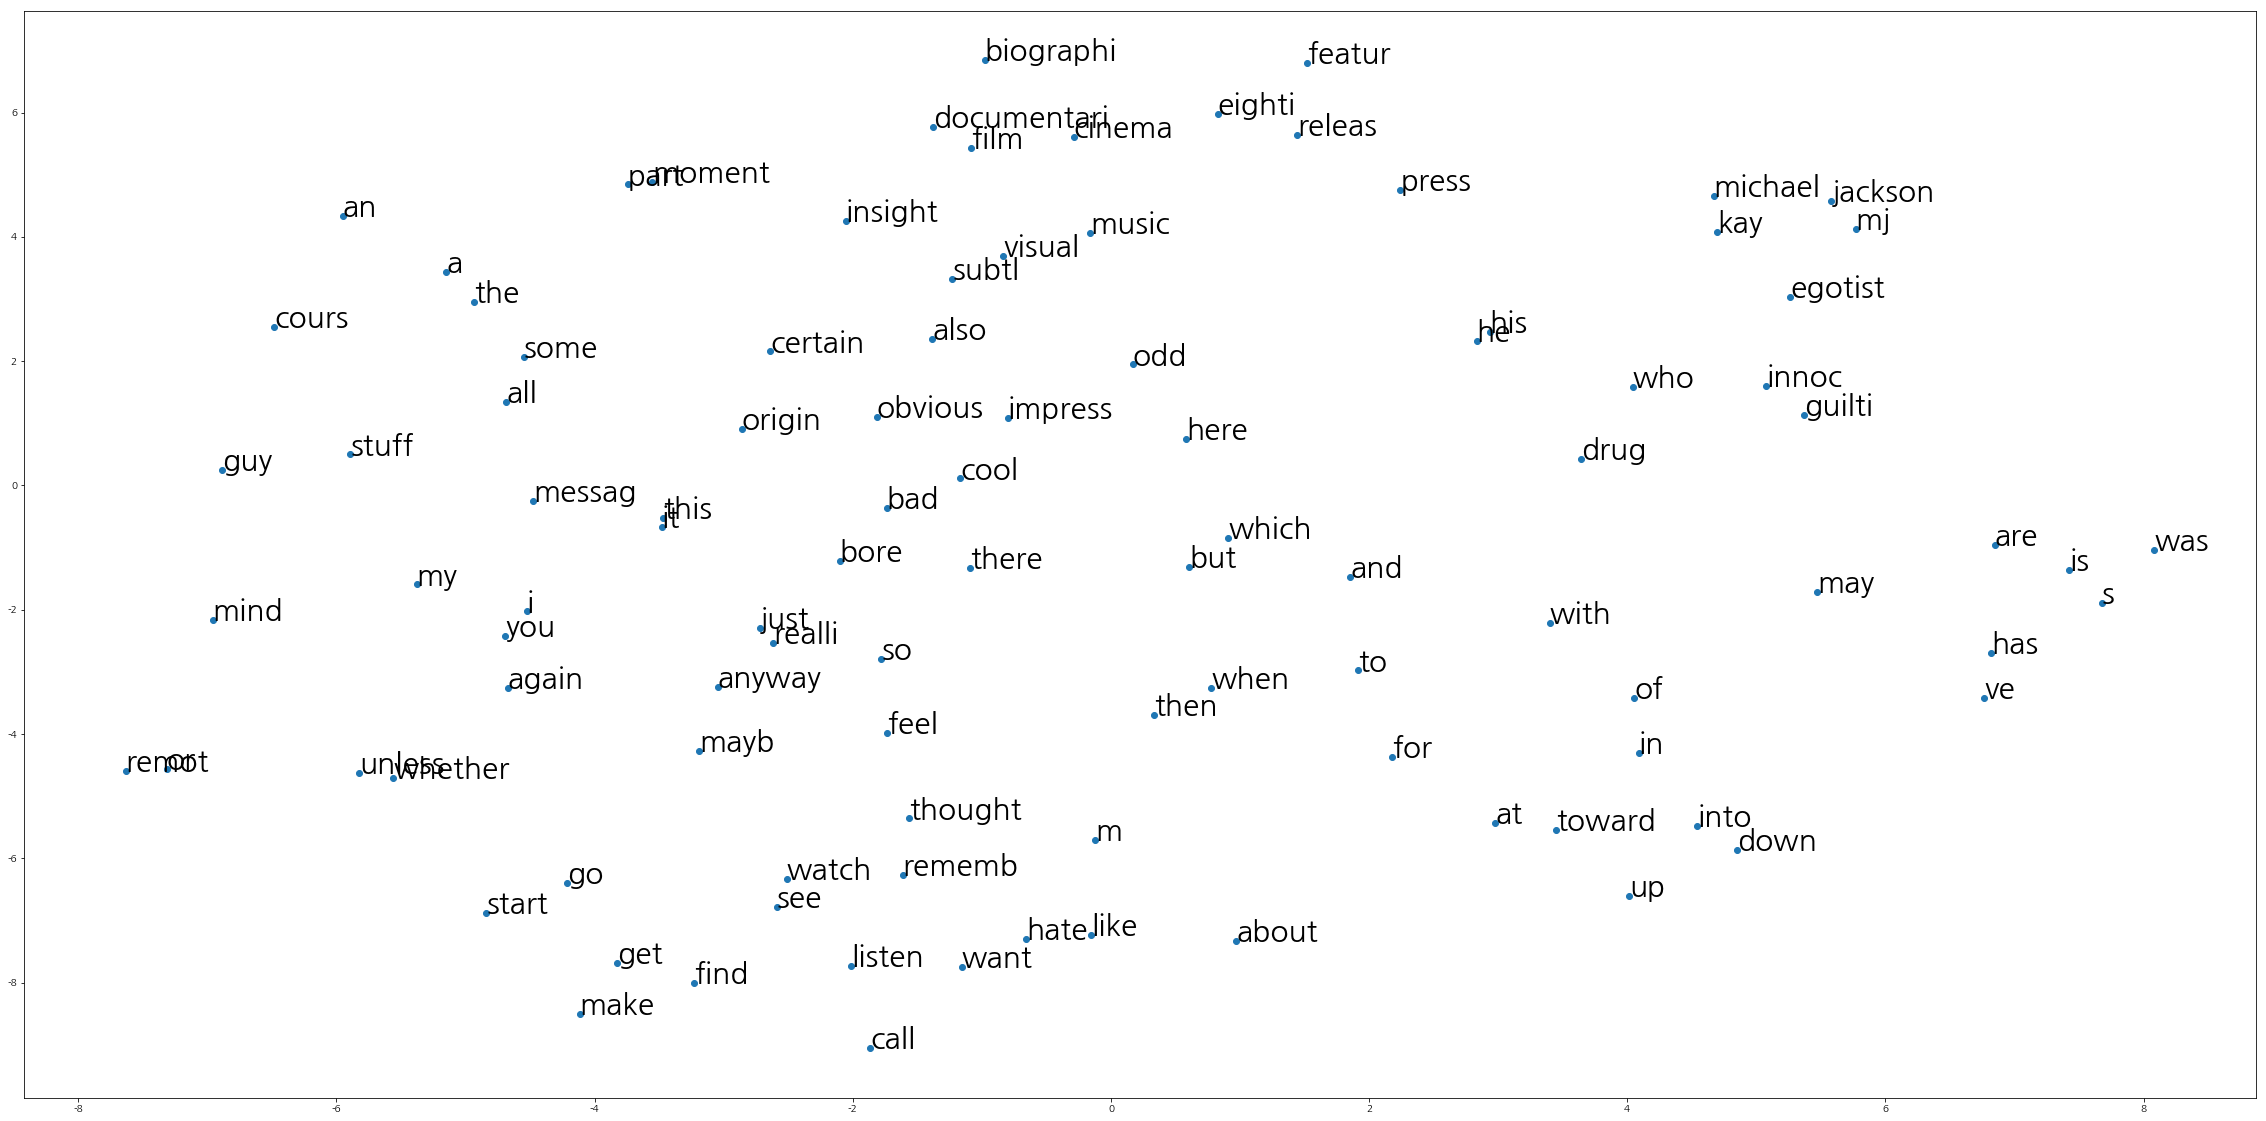

In [ ]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [ ]:
import numpy as np

def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화 한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.1
    # Index2word는 모델의 사전에 있는 단어명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화 한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [ ]:
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.
    
    # 카운터를 초기화 한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")
    
    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [ ]:
# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(\
        reviews["review"], KaggleWord2VecUtility.review_to_wordlist,\
        workers=4)
    return clean_reviews

In [ ]:
%time trainDataVecs = getAvgFeatureVecs(\
    getCleanReviews(train), model, num_features ) 

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 1min 56s, sys: 4.46 s, total: 2min
Wall time: 3min 33s


In [ ]:
%time testDataVecs = getAvgFeatureVecs(\
        getCleanReviews(test), model, num_features )

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 2min 17s, sys: 5.41 s, total: 2min 22s
Wall time: 4min 10s


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

In [ ]:
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

CPU times: user 1min 5s, sys: 972 ms, total: 1min 6s
Wall time: 26.4 s


In [ ]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train['sentiment'], cv=10, scoring='roc_auc'))

CPU times: user 8min 12s, sys: 3.95 s, total: 8min 16s
Wall time: 2min 35s


In [ ]:
score

0.9051908800000001

In [ ]:
result = forest.predict( testDataVecs )

In [ ]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('data/Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), 
              index=False, quoting=3 )

* 300features_40minwords_10text 일 때 0.90709436799999987
* 300features_50minwords_20text 일 때 0.86815798399999999

In [ ]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

104


0    12552
1    12448
Name: sentiment, dtype: int64

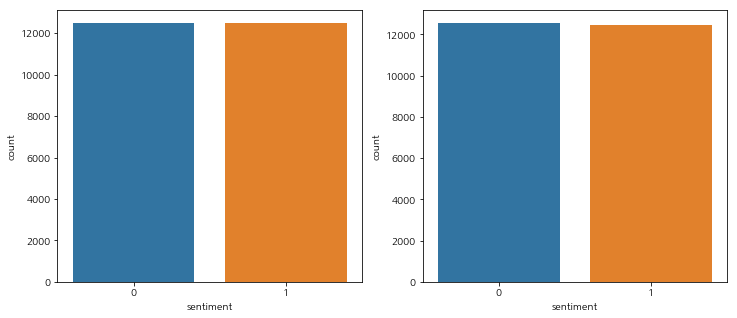

In [ ]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [ ]:
544/578

0.9411764705882353